In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# data 폴더 csv 불러올때 파일명확인
from glob import glob 

# type 변환
from datetime import datetime, timedelta

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# 데이터 시각화
import plotly
import random

line_color = ['#FFBF00', '#FF7F50', '#DE3163', 
             '#9FE2BF', '#40E0D0', '#6495ED', 
             '#117A65', '#2471A3', '#CCCCFF', 
             '#8E44AD', '#CD5C5C', '#F08080', 
             '#FA8072', '#E9967A', '#FFA07A', ]

# for문 진행상황 tracking
from tqdm import tqdm

# 전처리
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#ML 알고리즘
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingRegressor

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Feature 중요도 _ LightGBM
from lightgbm import plot_importance
# fig, ax = plt.subplots(figsize=(10, 12))
# plot_importance(lgbm_wrapper, ax=ax)


# 경고 제거 (판다스가 에러 메세지를 자주 만들어 내기 때문에 이를 일단 무시하도록 설정합니다.)
import sys
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import joblib 
import os

import random
import requests
import calendar
import time

C:\Miniconda\envs\py38_default\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# 생략할 것
path = 'Z:/team/과제2_dataset/dataset'
test_raw = read_csv_by_dir('/'.join([path, 'test']))
test_raw.to_csv('./test_raw.csv')

In [211]:
train_raw = pd.read_csv('Z:/team/과제2_dataset/dataset/train/train.csv')
submission_sample_raw = pd.read_csv('Z:/team/과제2_dataset/dataset/submission_sample.csv')

def read_csv_by_dir(path):
    df_raw = pd.DataFrame()
    #os.listdir()은 해당 경로에 있는 파일들을 리스트로 만들어줌
    for files in tqdm(os.listdir(path)):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path, files]))
        df_raw = pd.concat((df_raw, df), axis=0)
    return df_raw

test_raw =pd.read_csv('Z:/team/과제2_dataset/dataset/test_raw/test_raw.csv')
test_raw = test_raw.sort_values(by='TIME')
test_raw = test_raw.reset_index(drop=True)
test_raw = test_raw.drop(["Unnamed: 0"], axis=1)

In [632]:
# 원본(raw)은 유지하기
train = train_raw.copy()
test = test_raw.copy()
submission = submission_sample_raw.copy()

In [633]:
# time컬럼을 문자형에서 날짜 타입으로 변경
train.TIME = pd.to_datetime(train['TIME'])
test.TIME = pd.to_datetime(test['TIME'])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

#밀리초 단위가 5밀리초씩 늦은 row가 있어서 이를 정각으로 맞춰주기 위한 작업
from datetime import datetime, timedelta
train['MINUTE']=train['TIME'].dt.minute
train['MOD']=train['MINUTE']%10
train.loc[train['MOD'] == 9, 'TIME'] = train['TIME']+timedelta(milliseconds=5)
train.drop(['MINUTE','MOD'], axis=1, inplace=True)

test['MINUTE']=test['TIME'].dt.minute
test['MOD']=test['MINUTE']%10
test.loc[test['MOD'] == 9, 'TIME'] = test['TIME']+timedelta(milliseconds=5)
test.drop(['MINUTE','MOD'], axis=1, inplace=True)

In [634]:
def weather_generator(location):
    #동해, 원덕, 궁촌 3개 중 1개만 실행
    if location == "donghae":
        #동해 기상데이터 불러오기
        df_2019 = pd.read_csv('Z:/team/donghae_weather/donghae_weather_2019.csv', encoding='cp949')
        df_2020 = pd.read_csv('Z:/team/donghae_weather/donghae_weather_2020.csv', encoding='cp949')
        df_2021 = pd.read_csv('Z:/team/donghae_weather/donghae_weather_2021.csv', encoding='cp949')
        weather_test = pd.read_csv('Z:/team/donghae_weather/donghae_weather_test.csv', encoding='cp949')
        
    elif location == "wondeok":
        #원덕읍 기상데이터 불러오기
        df_2019 = pd.read_csv('Z:/team/1111_upload/wondeok_weather_2019.csv', encoding='cp949')
        df_2020 = pd.read_csv('Z:/team/1111_upload/wondeok_weather_2020.csv', encoding='cp949')
        df_2021 = pd.read_csv('Z:/team/1111_upload/wondeok_weather_2021.csv', encoding='cp949')
        weather_test = pd.read_csv('Z:/team/1111_upload/wondeok_weather_test.csv', encoding='cp949')

    elif location == "goongchon":
        #궁촌 기상데이터 불러오기
        df_2019 = pd.read_csv('Z:/team/1111_upload/goongchon_weather_2019.csv', encoding='cp949')
        df_2019 = df_2019[:8661]
        df_2020 = pd.read_csv('Z:/team/1111_upload/goongchon_weather_2020.csv', encoding='cp949')
        df_2020 = df_2020[:8784]
        df_2021 = pd.read_csv('Z:/team/1111_upload/goongchon_weather_2021.csv', encoding='cp949')
        df_2021 = df_2021[:744]
        weather_test = pd.read_csv('Z:/team/1111_upload/goongchon_weather_test.csv', encoding='cp949')
        weather_test = weather_test[:7343]

    #train set에 쓰이는 기상 데이터 3개년도를 합치고 가공
    donghae_result = pd.concat([df_2019, df_2020, df_2021], ignore_index=True)
    donghae_result.rename(columns={'일시':'TIME'}, inplace=True)
    donghae_result['TIME']=pd.to_datetime(donghae_result['TIME'])

    #test set에 쓰이는 기상 데이터 가공
    weather_test.rename(columns={'일시':'TIME'}, inplace=True)
    weather_test['TIME']=pd.to_datetime(weather_test['TIME'])

    #원하는 컬럼만 갖고오기
    donghae_temp_train = donghae_result.loc[:, ['TIME', '기온(°C)', '습도(%)', '증기압(hPa)', '현지기압(hPa)']]
    weather_test = weather_test.loc[:, ['TIME', '기온(°C)', '습도(%)', '증기압(hPa)', '현지기압(hPa)']]

    #결측치 보간
    donghae_temp_train = donghae_temp_train.set_index('TIME')
    donghae_temp_train = donghae_temp_train.interpolate(method = 'time')
    donghae_temp_train.reset_index(drop = False, inplace = True)

    #결측치 보간
    weather_test = weather_test.set_index('TIME')
    weather_test = weather_test.interpolate(method = 'time')
    weather_test.reset_index(drop = False, inplace = True)

    print("기상청 데이터를 10분단위로 생성합니다.")
    #날씨데이터는 정각의 데이터밖에 없다.
    #10분 단위로 데이터를 생성해주기 위한 작업이다.
    weather_test_ = weather_test
    new_row = pd.DataFrame({'TIME':[np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]}
                          )
    j=0
    for i in tqdm(range(1, weather_test_.shape[0]+1)):
        weather_test_ = pd.concat([weather_test_.iloc[:i+j], new_row, weather_test_.iloc[i+j:]], ignore_index=True)
        j+=5

    weather_test__ = weather_test_

    for i in tqdm(range(weather_test__.shape[0])):
        weather_test__.iloc[i+1:i+2,[0]] = weather_test__.iloc[i:i+1,[0]]+timedelta(minutes=10)

    weather_test__ = weather_test__.set_index('TIME')
    weather_test__ = weather_test__.interpolate(method = 'time')
    weather_test__.reset_index(drop = False, inplace = True)

    weather_test = weather_test__
    print("기상청 데이터 생성이 완료됐습니다.")

    weather_test['TIME']=pd.to_datetime(weather_test['TIME'])
    
    global train
    global test
    
    train_temp_join = pd.merge(train, donghae_temp_train, left_on='TIME', right_on='TIME', how='left')
    test_temp_join = pd.merge(test, weather_test, left_on='TIME', right_on='TIME', how='left')

    train_temp_join = train_temp_join.set_index('TIME')
    train_temp_join = train_temp_join.interpolate(method='time')
    train_temp_join.reset_index(drop = False, inplace = True)
    train_temp_join.rename(columns={'기온(°C)':'TEMP', '습도(%)':'HUMID', '증기압(hPa)':'VAPOR', '현지기압(hPa)':'PRESS'}, inplace=True)
    test_temp_join.rename(columns={'기온(°C)':'TEMP', '습도(%)':'HUMID', '증기압(hPa)':'VAPOR', '현지기압(hPa)':'PRESS'}, inplace=True)

    #날씨 정보가 추가된 버전으로 train 덮어쓰기
    train = train_temp_join
    #날씨 정보가 추가된 버전으로 test 덮어쓰기
    test = test_temp_join
    
    return train, test


In [635]:
train, test = weather_generator("donghae")

기상청 데이터를 10분단위로 생성합니다.


100%|██████████████████████████████████████████████████████████████████████████| 44064/44064 [00:32<00:00, 1366.25it/s]


기상청 데이터 생성이 완료됐습니다.


In [371]:
#이상치 판독 함수
def outlier(sets, column):
    q1 = sets[column].quantile(0.25)
    q3 = sets[column].quantile(0.75)
    iqr = q3-q1
    top_fence = sets[sets[column] > q3+1.5*iqr].shape[0]
    bottom_fence = sets[sets[column] < q1-1.5*iqr].shape[0] 
    print("----{}----".format(column))
    print("이상치 범위는 {:.3f}이상, {:.3f}이하".format(q3+1.5*iqr,q1-1.5*iqr))
    print("큰 이상치 값의 개수는 {}개이고 전체 중 {:.3f}%".format(top_fence, (top_fence/sets.shape[0])*100))
    print("작은 이상치 값의 개수는 {}개이고 전체 중 {:.3f}%".format(bottom_fence, (bottom_fence/sets.shape[0])*100))

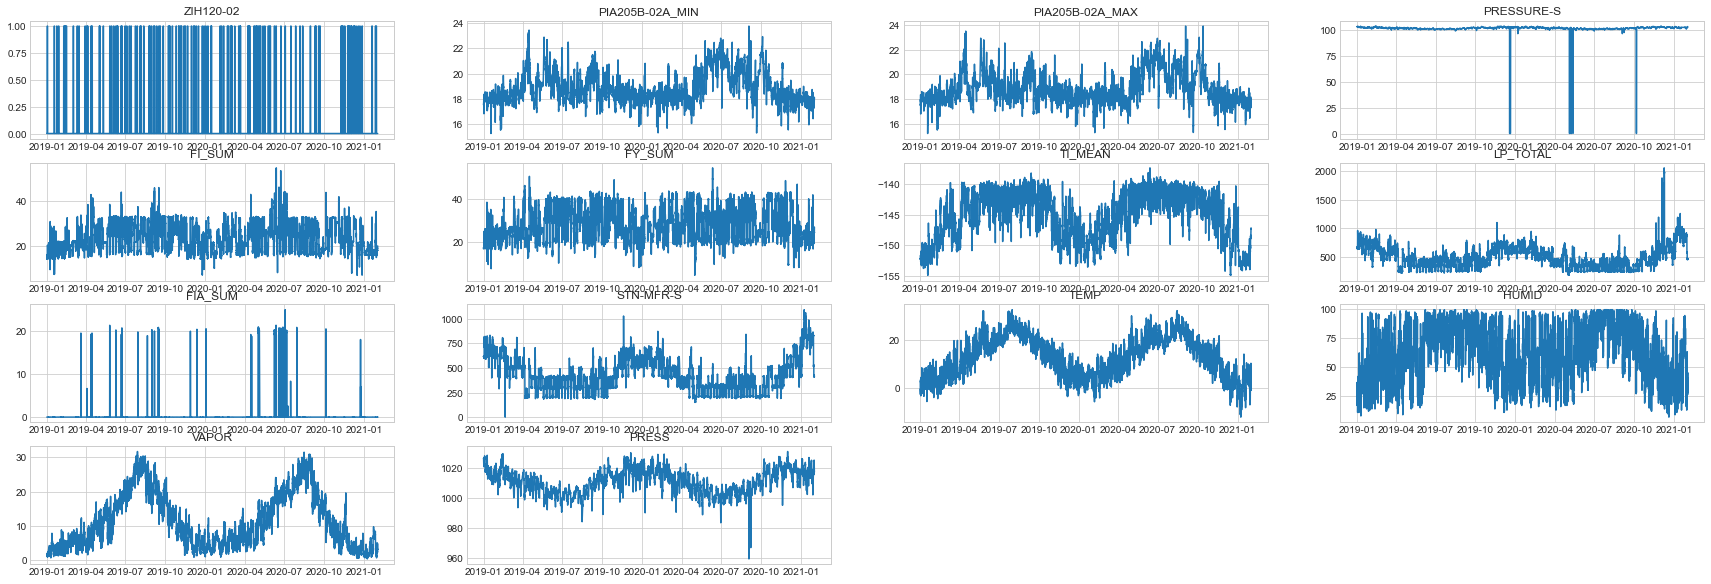

In [331]:
#전체 변수들의 그래프를 그려보고 추이를 확인
#이상치가 의심되는 그래프들은 해당 그래프 하나만 크게 다시 그려보자

plot_list = list(train.columns)
plot_list.remove('TIME')

plt.figure(figsize=(30,10))

idx=1
for var in plot_list:
    plt.subplot(4,4,idx)
    plt.plot(train['TIME'], train[var])
    plt.title(var)
    idx+=1

In [636]:
#이상치 보간이 필요한 columns list
remove_list = ["PRESS", "PRESSURE-S", "LP_TOTAL", "STN-MFR-S", "FI_SUM"] 

#이상치 보간해주는 함수
def remove_outlier(remove_list,method_):
    global train
    for var in remove_list:
        q1 = train[var].quantile(0.25)
        q3 = train[var].quantile(0.75)
        iqr = q3-q1
        train.loc[train[var]<=q1-1.5*iqr, var] = np.NaN
        train.loc[train[var]>=q3+1.5*iqr, var] = np.NaN
        train = train.set_index('TIME')
        train = train.interpolate(method=method_)
        train.reset_index(drop=False, inplace=True)
    return train

train = remove_outlier(remove_list,"time")

In [387]:
outlier(test,'PRESSURE-S')
outlier(test,'PRESS')
outlier(test,'FY_SUM')
outlier(test,'TI_MEAN')
outlier(test, 'LP_TOTAL')
outlier(test, 'STN-MFR-S')
outlier(test, 'FI_SUM')

----PRESSURE-S----
이상치 범위는 103.800이상, 98.200이하
큰 이상치 값의 개수는 0개이고 전체 중 0.000%
작은 이상치 값의 개수는 5739개이고 전체 중 17.366%
----PRESS----
이상치 범위는 1032.383이상, 987.450이하
큰 이상치 값의 개수는 0개이고 전체 중 0.000%
작은 이상치 값의 개수는 0개이고 전체 중 0.000%
----FY_SUM----
이상치 범위는 46.748이상, 9.450이하
큰 이상치 값의 개수는 67개이고 전체 중 0.203%
작은 이상치 값의 개수는 2개이고 전체 중 0.006%
----TI_MEAN----
이상치 범위는 -133.341이상, -149.931이하
큰 이상치 값의 개수는 0개이고 전체 중 0.000%
작은 이상치 값의 개수는 1482개이고 전체 중 4.484%
----LP_TOTAL----
이상치 범위는 869.165이상, 66.477이하
큰 이상치 값의 개수는 383개이고 전체 중 1.159%
작은 이상치 값의 개수는 0개이고 전체 중 0.000%
----STN-MFR-S----
이상치 범위는 775.722이상, 19.494이하
큰 이상치 값의 개수는 62개이고 전체 중 0.188%
작은 이상치 값의 개수는 0개이고 전체 중 0.000%
----FI_SUM----
이상치 범위는 45.285이상, 4.789이하
큰 이상치 값의 개수는 552개이고 전체 중 1.670%
작은 이상치 값의 개수는 0개이고 전체 중 0.000%


In [22]:
# PRESSURE-S 중 0인 값
train[train['PRESSURE-S']==0] #7개.-> 완전 무작위 결측(MCAR)

,TIME,ZIH120-02,PIA205B-02A_MIN,PIA205B-02A_MAX,PRESSURE-S,FI_SUM,FY_SUM,TI_MEAN,LP_TOTAL,FIA_SUM,STN-MFR-S,TEMP,WATER,HUMID
50794,2019-12-19 17:40:00,0,17.679399,17.725201,0.0,21.704288,26.534203,-147.118721,677.224342,0.008352,598.458191,4.900000,0.0,30.000000
50795,2019-12-19 17:50:00,0,17.648899,17.694700,0.0,21.658799,26.417348,-147.092094,676.591438,0.008437,597.613159,4.750000,0.0,30.500000
50796,2019-12-19 18:00:00,0,17.633699,17.661100,0.0,21.692168,26.275497,-147.090408,677.925323,0.008740,594.390259,4.600000,0.0,31.000000
50797,2019-12-19 18:10:00,0,17.621500,17.655001,0.0,21.644349,26.473938,-147.088577,677.953415,0.008317,597.949280,4.466667,0.0,31.000000
50798,2019-12-19 18:20:00,0,17.594000,17.636700,0.0,21.656146,26.338631,-147.100380,678.369843,0.008276,594.539795,4.333333,0.0,31.000000
50799,2019-12-19 18:30:00,0,17.578699,17.597000,0.0,21.689471,26.521434,-147.096512,678.530907,0.007935,596.994141,4.200000,0.0,31.000000
92692,2020-10-05 16:40:00,0,21.243900,21.280500,0.0,26.969306,35.222929,-141.408875,364.785339,0.011455,310.871460,17.800000,0.0,35.666667


<AxesSubplot:xlabel='TIME', ylabel='PRESSURE-S'>

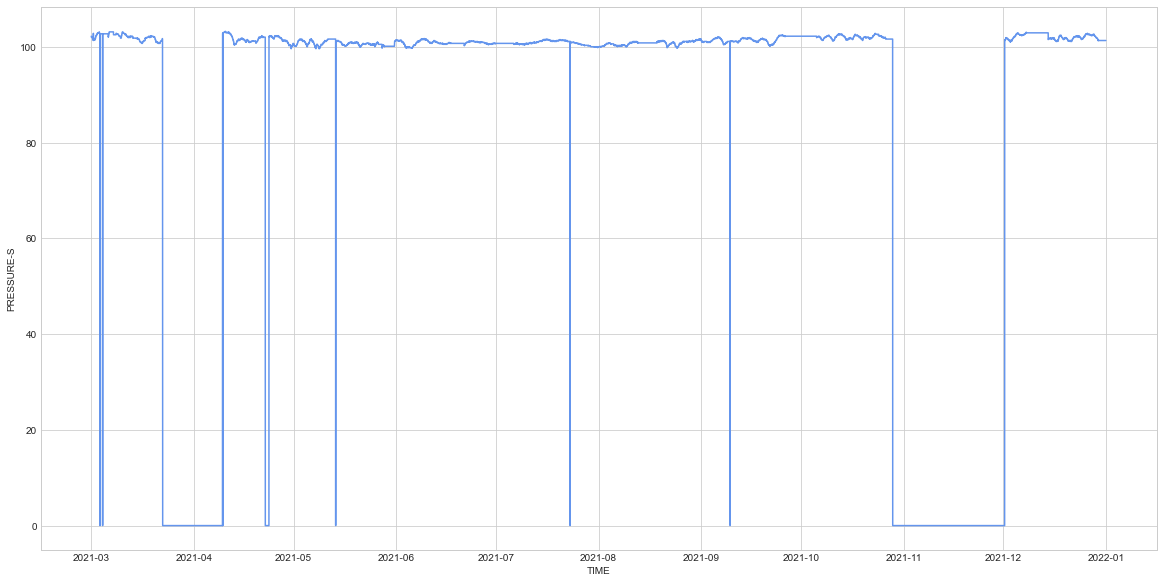

In [21]:
# test set PRESSURE-S 그래프 그리기
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=test['TIME'], y=test['PRESSURE-S'], ax=ax, color=random.choice(line_color))

In [22]:
test[test['PRESSURE-S']==0].shape[0] #0값이 1823개나 됨.

1823

In [ ]:
#test set에 이상치가 너무 많음.
# 대안1) 이 정도 수준이면 test set을 columns에서 과감히 삭제!
# 대안2) train set의 통계 정보로 보간하기(data leakage 예방)
# 대안3) 이상치가 없는 기상청 데이터(현지기압)를 끌고 와서 대체해주기!

<AxesSubplot:xlabel='TIME', ylabel='LP_TOTAL'>

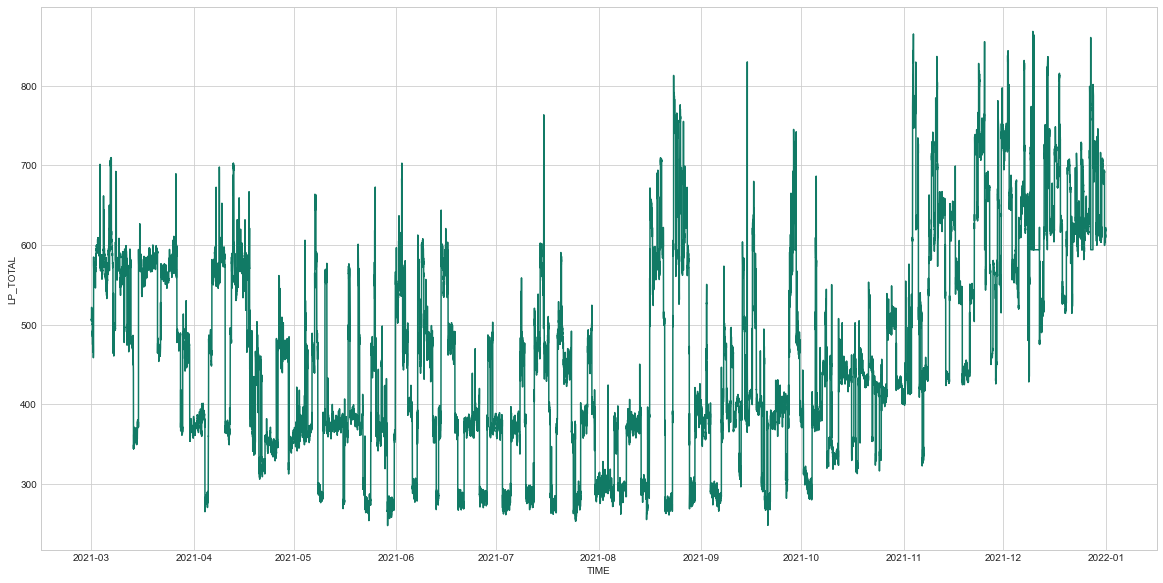

In [136]:
# LP_TOTAL 그래프 그리기
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=test['TIME'], y=test['LP_TOTAL'], ax=ax, color=random.choice(line_color))

In [116]:
#test set의 lP_TOTAL값 중 큰 이상치는 data leakage를 막기 위해 train set의 3분위수로 대체
outlier(test, 'LP_TOTAL')
#869.165 이상을 train LP_TOTAL의 3분위수로 대체!

----LP_TOTAL----
이상치 범위는 869.165이상, 66.477이하
큰 이상치 값의 개수는 383개이고 전체 중 1.159%
작은 이상치 값의 개수는 0개이고 전체 중 0.000%


In [637]:
LP_TOTAL_3qt = train['LP_TOTAL'].quantile(0.75)
test.loc[test['LP_TOTAL']>=869.165, 'LP_TOTAL'] = LP_TOTAL_3qt

In [38]:
# LP_TOTAL은 '재순환 및 재순환 회수를 거쳐 재액화기로 인입되는 LNG의 유량'이다.
# 왜 20년 말 유독 많았을까?

<AxesSubplot:xlabel='TIME', ylabel='STN-MFR-S'>

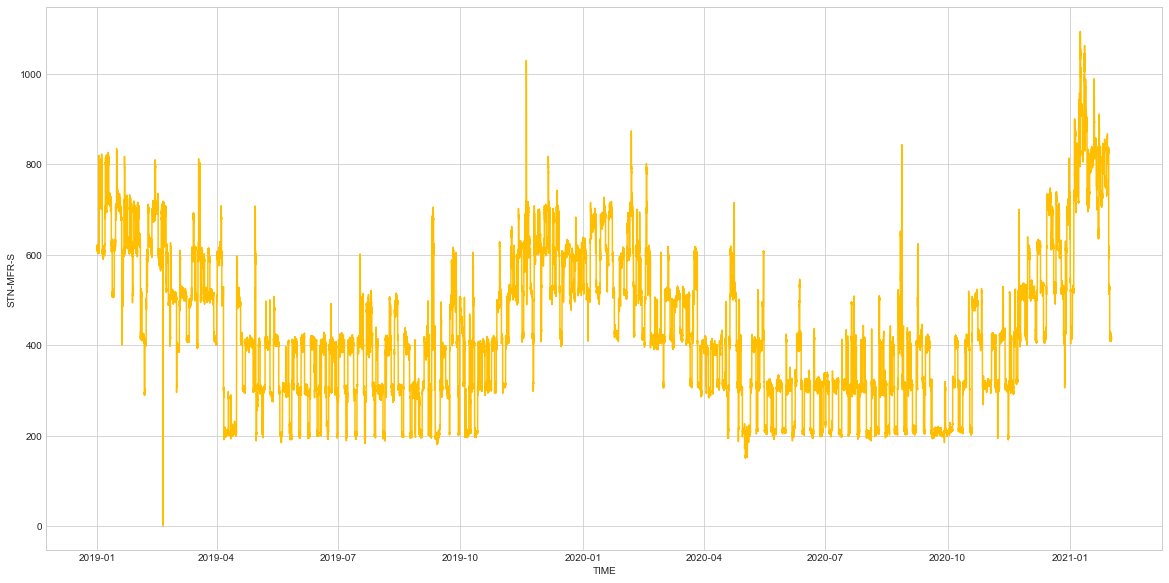

In [45]:
# STN-MFR-S 그래프 그리기
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=train['TIME'], y=train['STN-MFR-S'], ax=ax, color=random.choice(line_color))

In [12]:
outlier(train,'STN-MFR-S')

----STN-MFR-S----
이상치 범위는 854.290이상, -21.484이하
큰 이상치 값의 개수는 0개이고 전체 중 0.000%
작은 이상치 값의 개수는 0개이고 전체 중 0.000%


In [47]:
#Outlier로 잡히지 않았지만, 그래프 보면 극단적으로 낮은 부분이 보임
train[train['STN-MFR-S']<100] #모두 1로 오기입된 것으로 추정. -> 완전 무작위 결측(MCAR)

,TIME,ZIH120-02,PIA205B-02A_MIN,PIA205B-02A_MAX,PRESSURE-S,FI_SUM,FY_SUM,TI_MEAN,LP_TOTAL,FIA_SUM,STN-MFR-S,TEMP,WATER,HUMID,VAPOR
7169,2019-02-19 18:50:00,0,18.5156,18.5156,101.4,21.244764,26.158712,-148.787910,760.186951,0.010534,1.0,4.066667,0.0,89.833333,7.316667
7170,2019-02-19 19:00:00,0,18.4424,18.5156,101.4,21.281616,26.448539,-148.774040,760.186951,0.009988,1.0,4.000000,0.0,90.000000,7.300000
7171,2019-02-19 19:10:00,0,18.4454,18.4454,101.5,21.285773,26.459568,-148.765289,759.756180,0.011327,1.0,3.933333,0.0,90.333333,7.300000
7172,2019-02-19 19:20:00,0,18.4149,18.4454,101.5,21.277125,26.248064,-148.754486,759.420044,0.011535,1.0,3.866667,0.0,90.666667,7.300000


In [638]:
train.loc[train['STN-MFR-S'] < 2, 'STN-MFR-S'] = np.NaN
train = train.set_index('TIME')
train = train.interpolate(method='time')
train.reset_index(drop=False, inplace=True)

In [639]:
train['HOUR'] = train['TIME'].dt.hour #시간 변수 추가
test['HOUR'] = test['TIME'].dt.hour #시간 변수 추가
train['MONTH'] = train['TIME'].dt.month #월 변수 추가
test['MONTH'] = test['TIME'].dt.month #월 변수 추가
train['WEEK'] = train['TIME'].dt.weekofyear #주차 변수 추가
test['WEEK'] = test['TIME'].dt.weekofyear #주차 변수 추가
train['DAY'] = train['TIME'].dt.dayofyear #일 변수 추가
test['DAY'] = test['TIME'].dt.dayofyear #일 변수 추가
train['WEEKDAY'] = train['TIME'].dt.weekday #요일 변수 추가
test['WEEKDAY'] = test['TIME'].dt.weekday #요일 변수 추가

<AxesSubplot:title={'center':'PIA205B-02A_MIN grouped by MONTH'}, xlabel='MONTH', ylabel='PIA205B-02A_MIN'>

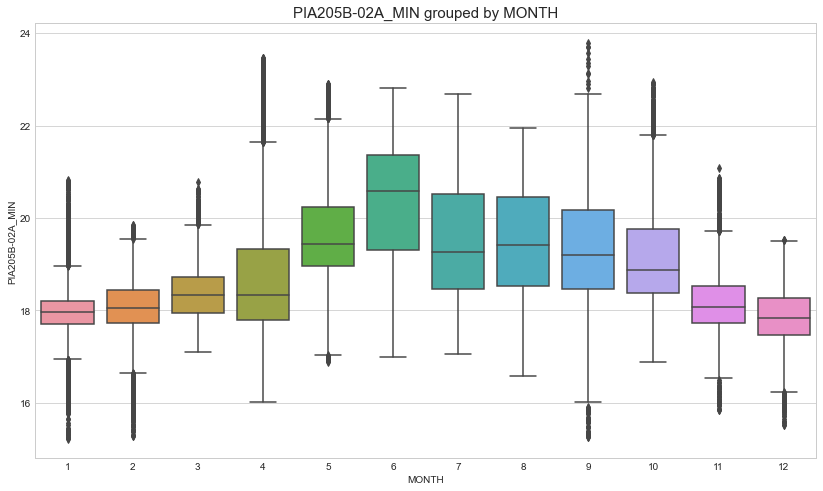

In [23]:
plt.figure(figsize=(14,8))
plt.title("PIA205B-02A_MIN grouped by MONTH", fontsize=15)
sns.boxplot(x="MONTH", y="PIA205B-02A_MIN", data=train)


<AxesSubplot:title={'center':'PIA205B-02A_MIN grouped by HOUR'}, xlabel='HOUR', ylabel='PIA205B-02A_MIN'>

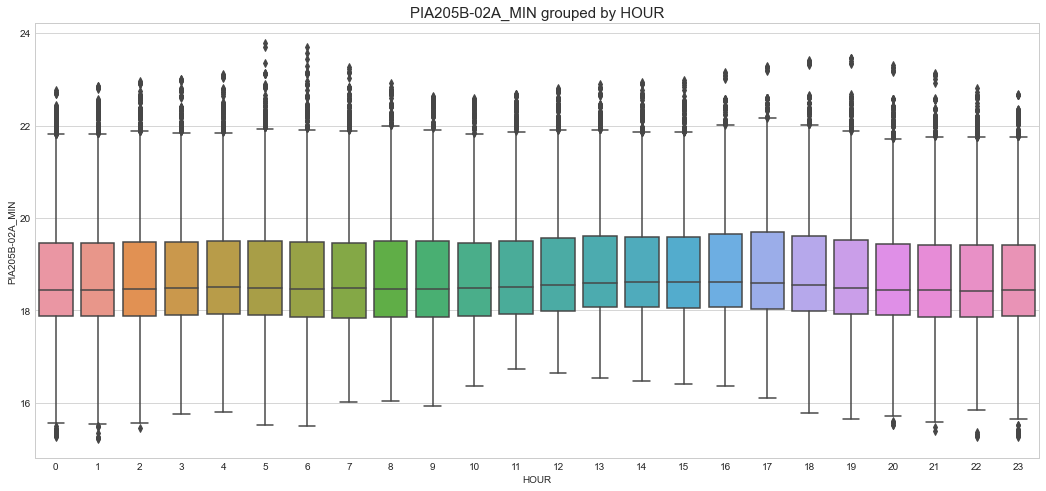

In [54]:
plt.figure(figsize=(18,8))
plt.title("PIA205B-02A_MIN grouped by HOUR", fontsize=15)
sns.boxplot(x="HOUR", y="PIA205B-02A_MIN", data=train)
#시간대가 끼치는 영향은 미미해보임.

<AxesSubplot:title={'center':'PIA205B-02A_MIN grouped by WEEK'}, xlabel='WEEK', ylabel='PIA205B-02A_MIN'>

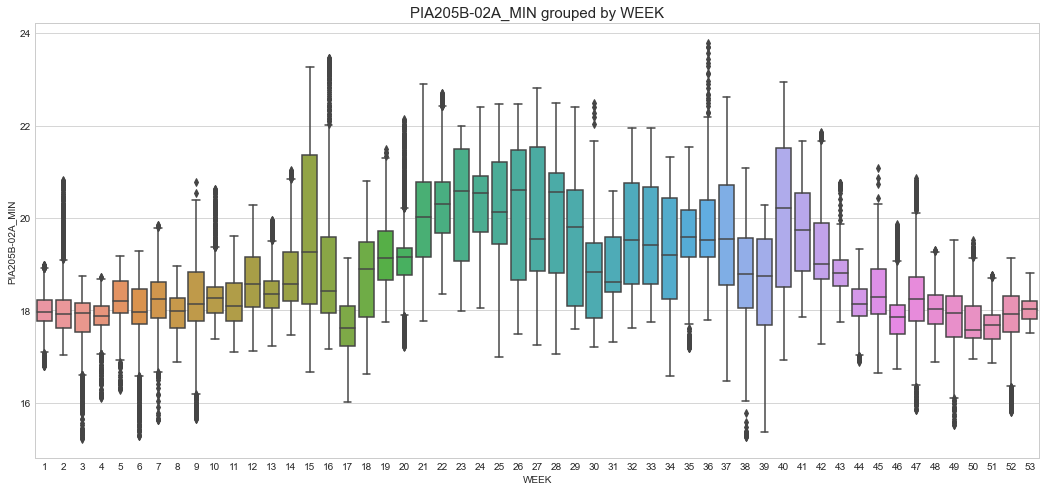

In [55]:
plt.figure(figsize=(18,8))
plt.title("PIA205B-02A_MIN grouped by WEEK", fontsize=15)
sns.boxplot(x="WEEK", y="PIA205B-02A_MIN", data=train)
#확실히 겨울이 처지긴 한다.

<AxesSubplot:title={'center':'PIA205B-02A_MIN grouped by WEEK'}, xlabel='WEEKDAY', ylabel='PIA205B-02A_MIN'>

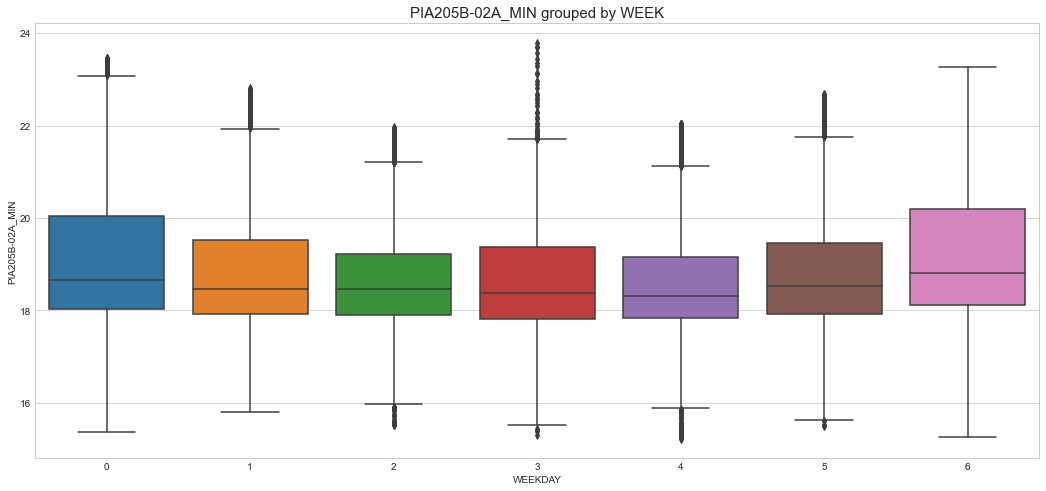

In [58]:
plt.figure(figsize=(18,8))
plt.title("PIA205B-02A_MIN grouped by WEEKDAY", fontsize=15)
sns.boxplot(x="WEEKDAY", y="PIA205B-02A_MIN", data=train)

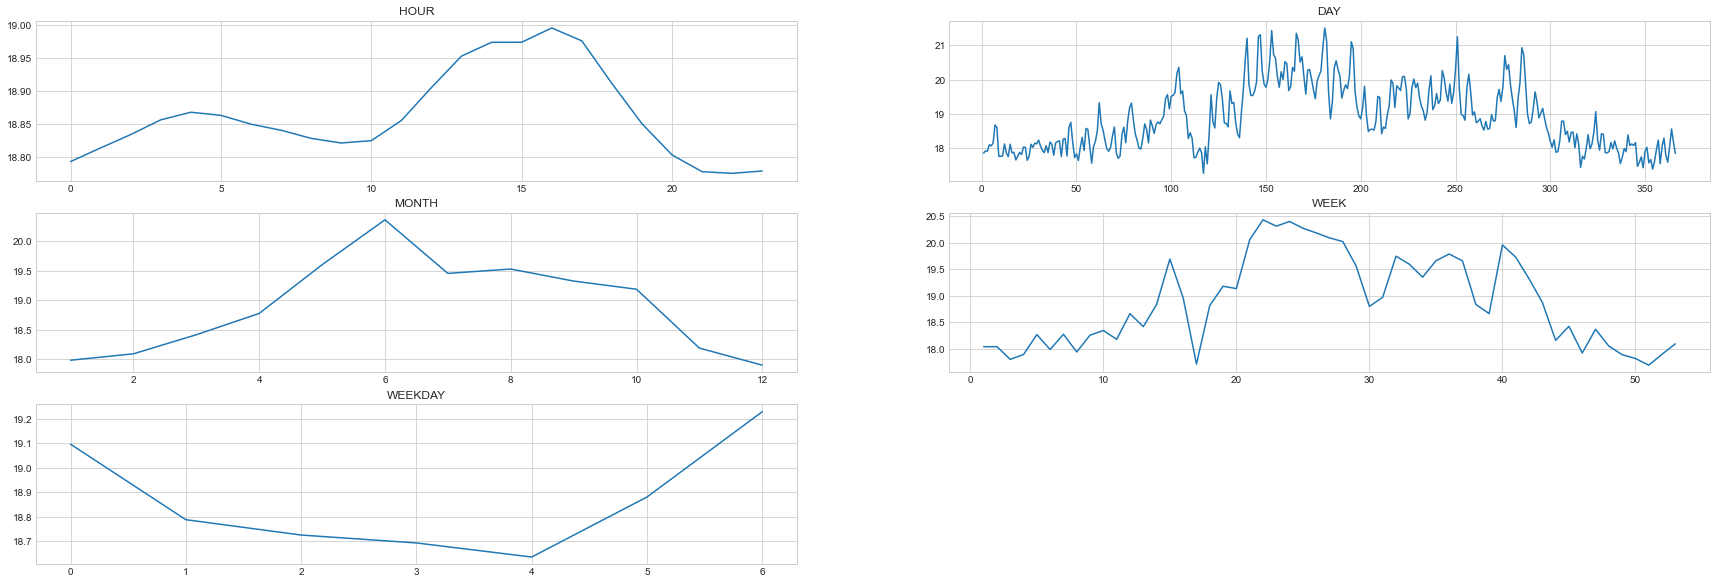

In [337]:
draw_list = ["HOUR","DAY","MONTH","WEEK","WEEKDAY"]

#시간 변수를 x축에, 압력 최댓값을 y축에 두고 그린 line plot 함수
def plot_per_time(sets, draw_list):
    plt.figure(figsize=(30,10))
    idx=1
    for var in draw_list:
        groupby = sets.groupby(var).mean()
        groupby.reset_index(inplace=True)
        plt.subplot(3,2,idx)
        plt.plot(groupby[var], groupby['PIA205B-02A_MAX'])
        plt.title(var)
        idx+=1
        
plot_per_time(train, draw_list)

In [640]:
#시간 변수의 주기성을 알기 위해 시간을 푸리에 특징으로 변환
#예를 들어 시간은 0~23이라는 int type으로 표현되는데 이렇게 되면 1월 1일 23시와 1월 2일 00시는 실제로 한 시간의 차이를 가짐에도 23의 차이를 갖는 꼴이 된다.
#이를 해결해주고자 삼각함수로 변환하여 시간이 연속성을 갖게 하자.
train['cos_day'] = np.cos(2*np.pi*(train.DAY/365))
test['cos_day'] = np.cos(2*np.pi*(test.DAY/365))
train['cos_hour'] = np.cos(2*np.pi*(train.HOUR/24))
test['cos_hour'] = np.cos(2*np.pi*(test.HOUR/24))

In [641]:
column_list = list(train.columns)
column_list.remove('TIME')
column_list_ = column_list

for column in tqdm(column_list_):
    train['LAG1_{}'.format(column)] = train[column].shift(1)
    
column_list_.remove('PIA205B-02A_MIN')
column_list_.remove('PIA205B-02A_MAX')
remove_list_ = column_list_

train.drop(remove_list_,axis=1,inplace=True)

train['LAG2_PIA205B-02A_MIN'] = train['PIA205B-02A_MIN'].shift(2)
train['LAG2_PIA205B-02A_MAX'] = train['PIA205B-02A_MAX'].shift(2)
train['LAG3_PIA205B-02A_MIN'] = train['PIA205B-02A_MIN'].shift(3)
train['LAG3_PIA205B-02A_MAX'] = train['PIA205B-02A_MAX'].shift(3)
train['LAG4_PIA205B-02A_MIN'] = train['PIA205B-02A_MIN'].shift(4)
train['LAG4_PIA205B-02A_MAX'] = train['PIA205B-02A_MAX'].shift(4)
train['LAG5_PIA205B-02A_MIN'] = train['PIA205B-02A_MIN'].shift(5)
train['LAG5_PIA205B-02A_MAX'] = train['PIA205B-02A_MAX'].shift(5)
train['LAG6_PIA205B-02A_MIN'] = train['PIA205B-02A_MIN'].shift(6)
train['LAG6_PIA205B-02A_MAX'] = train['PIA205B-02A_MAX'].shift(6)

#lAG1과 LAG2의 차
train['MIN_DIFF_12'] = train['LAG1_PIA205B-02A_MIN']-train['LAG2_PIA205B-02A_MIN']
train['MAX_DIFF_12'] = train['LAG1_PIA205B-02A_MAX']-train['LAG2_PIA205B-02A_MAX']


#lAG1과 LAG2의 차의 제곱
train['MIN_DIFF_12SQ'] = train['MIN_DIFF_12']**2
train['MAX_DIFF_12SQ'] = train['MAX_DIFF_12']**2


#lAG1과 LAG2의 곱
train['MIN_DIFF_12X'] = train['LAG1_PIA205B-02A_MIN']*train['LAG2_PIA205B-02A_MIN']
train['MAX_DIFF_12X'] = train['LAG1_PIA205B-02A_MAX']*train['LAG2_PIA205B-02A_MAX']

#LAG1 MIN과 LAG1 MAX의 차
train['DIFF_MAXMIN'] = train['LAG1_PIA205B-02A_MAX'] - train['LAG1_PIA205B-02A_MIN']



train_ = train[6:]

y = train_.iloc[:,1:3]
x = train_.iloc[:,3:]


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 403.89it/s]


In [642]:

#test_data 만들기
column_list = list(test.columns)
column_list.remove('TIME')
column_list_ = column_list

for column in column_list_:
    test = test.rename(columns={column:'LAG1_{}'.format(column)})

test['LAG2_PIA205B-02A_MIN'] = test['LAG1_PIA205B-02A_MIN'].shift(1)
test['LAG2_PIA205B-02A_MAX'] = test['LAG1_PIA205B-02A_MAX'].shift(1)
test['LAG3_PIA205B-02A_MIN'] = test['LAG1_PIA205B-02A_MIN'].shift(2)
test['LAG3_PIA205B-02A_MAX'] = test['LAG1_PIA205B-02A_MAX'].shift(2)
test['LAG4_PIA205B-02A_MIN'] = test['LAG1_PIA205B-02A_MIN'].shift(3)
test['LAG4_PIA205B-02A_MAX'] = test['LAG1_PIA205B-02A_MAX'].shift(3)
test['LAG5_PIA205B-02A_MIN'] = test['LAG1_PIA205B-02A_MIN'].shift(4)
test['LAG5_PIA205B-02A_MAX'] = test['LAG1_PIA205B-02A_MAX'].shift(4)
test['LAG6_PIA205B-02A_MIN'] = test['LAG1_PIA205B-02A_MIN'].shift(5)
test['LAG6_PIA205B-02A_MAX'] = test['LAG1_PIA205B-02A_MAX'].shift(5)

#lAG1과 LAG2의 차
test['MIN_DIFF_12'] = test['LAG1_PIA205B-02A_MIN']-test['LAG2_PIA205B-02A_MIN']
test['MAX_DIFF_12'] = test['LAG1_PIA205B-02A_MAX']-test['LAG2_PIA205B-02A_MAX']


#lAG1과 LAG2의 차의 제곱
test['MIN_DIFF_12SQ'] = test['MIN_DIFF_12']**2
test['MAX_DIFF_12SQ'] = test['MAX_DIFF_12']**2


#lAG1과 LAG2의 곱
test['MIN_DIFF_12X'] = test['LAG1_PIA205B-02A_MIN']*test['LAG2_PIA205B-02A_MIN']
test['MAX_DIFF_12X'] = test['LAG1_PIA205B-02A_MAX']*test['LAG2_PIA205B-02A_MAX']

#LAG1 MIN과 LAG1 MAX의 차
test['DIFF_MAXMIN'] = test['LAG1_PIA205B-02A_MAX'] - test['LAG1_PIA205B-02A_MIN']

test_ = test[5::6]
test_.drop('TIME',axis=1,inplace=True)
test_.reset_index(drop=True,inplace=True)
test_with_sub = pd.concat((submission,test_), axis=1)
test_data = test_with_sub.iloc[:,3:]
#columns 순서 train data와 동일하게 맞추기
test_data = test_data.reindex(columns=x.columns)

In [643]:
####주의####
#중요도 낮은 변수 drop하는 버전.
#평소엔 이 코드 생략하고 실행할 것!!!!!
#test set에 이상치가 많은 변수는 보간을 고민하다가 과감히 없앴음.
x = x.drop(["LAG1_ZIH120-02", "LAG1_HOUR", "LAG1_PRESSURE-S", "LAG1_MONTH", "LAG1_WEEK", "LAG1_DAY", 'LAG1_PRESS', 'LAG1_VAPOR', 'LAG1_HUMID', 'LAG1_FY_SUM', 'LAG1_FIA_SUM', 'LAG1_TI_MEAN', 'LAG1_LP_TOTAL'], axis=1)
test_data = test_data.drop(["LAG1_ZIH120-02", "LAG1_HOUR", "LAG1_PRESSURE-S", "LAG1_MONTH", "LAG1_WEEK", "LAG1_DAY", 'LAG1_PRESS', 'LAG1_VAPOR', 'LAG1_HUMID', 'LAG1_FY_SUM', 'LAG1_FIA_SUM', 'LAG1_TI_MEAN', 'LAG1_LP_TOTAL'], axis=1)

In [ ]:
#상관관계 분석

def draw_corr_heatmap(data):
    colormap = plt.cm.PuBu
    plt.figure(figsize=(11,15))
    plt.title("Correlation of Features", y=1.05, size=15)
    sns.heatmap(data.corr().loc[:,['LAG1_PIA205B-02A_MIN','LAG1_PIA205B-02A_MAX']], cmap=colormap, linewidths=0.03, linecolor="white", annot=True)

draw_corr_heatmap(x)

#단순히 상관관계만 보고 변수를 SELECT or DROP하는 건 무리가 있음!

In [ ]:


#========= 11.23. 04:52 to현준. 이 전 코드까지 복붙해서 가져가셈 ========#

# test_data로 predict하고 x랑 y로 train_test_split하면 됨


In [602]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [335]:
#랜덤포레스트 그리드서치
start = time.time()

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = {"n_estimators":[1000],
    "max_depth":(24,28,32),
         "min_samples_split":(3,5)}

grid_cv = GridSearchCV(rf,
                      param_grid=params,
                      cv=kfold,
                      scoring = 'neg_mean_absolute_error')

grid_cv.fit(x_train, y_train)
grid_cv.score(x_train, y_train)

print(grid_cv.best_estimator_)
print(grid_cv.best_params_)


print("runtime:", time.time()-start)

RandomForestRegressor(max_depth=32, min_samples_split=3, n_estimators=1000,
                      n_jobs=-1)
{'max_depth': 32, 'min_samples_split': 3, 'n_estimators': 1000}
runtime: 1623.4505867958069


In [ ]:
#교차검증
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=kfold)
print("CV score list:",cv_scores)
print("CV score: {:.8f}".format(cv_scores.mean()))

In [457]:
start = time.time()

def kfold_RF(n):

    kfold = KFold(n_splits=n, shuffle=True, random_state=42)
    folds = []
    for train_idx, val_idx in kfold.split(x,y):
        folds.append((train_idx, val_idx))

    RF_model_dict = {}
    MAE = []

    for f in range(n):
        print("----------{}회째 folds-----------".format(f+1))
        train_idx, val_idx = folds[f]

        x_train, x_val, y_train, y_val = x.iloc[train_idx], x.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]

        RF_model = RandomForestRegressor(max_depth=32,
                                      n_estimators=2000,
                                  min_samples_leaf=3,
                                      min_samples_split=3,
                                 n_jobs=-1)

        RF_model.fit(x_train, y_train)
        y_pred = RF_model.predict(x_val)
        mae = mean_absolute_error(y_val, y_pred)
        MAE.append(mae)
        print("{} fold MAE score: {:.8f}".format(f+1,mae))
        RF_model_dict[f] = RF_model

    MAE_mean = np.array(MAE)
    print("---------------------------")
    print("k-fold MAE mean: {:.8f}".format(np.mean(MAE_mean)))
    
    RF_y_train = pd.DataFrame(np.zeros((x_train.shape[0],2)),columns=['min', 'max'])
    RF_y_test = pd.DataFrame(np.zeros((x_val.shape[0],2)),columns=['min', 'max'])
    RF_y_sub = pd.DataFrame(np.zeros((test_data.shape[0],2)),columns=['min', 'max'])

    for fold in tqdm(range(n)):
        RF_y_train += RF_model_dict[fold].predict(x_train)/n
        RF_y_test += RF_model_dict[fold].predict(x_val)/n
        RF_y_sub += RF_model_dict[fold].predict(test_data)/n
    print("runtime:", time.time()-start)
        
    return RF_y_train, RF_y_test, RF_y_sub

In [458]:
RF_y_train, RF_y_test, RF_y_sub = kfold_RF(10)

----------1회째 folds-----------
1 fold MAE score: 0.01033327
----------2회째 folds-----------
2 fold MAE score: 0.01058179
----------3회째 folds-----------
3 fold MAE score: 0.01017598
----------4회째 folds-----------
4 fold MAE score: 0.01030806
----------5회째 folds-----------
5 fold MAE score: 0.01051287
----------6회째 folds-----------
6 fold MAE score: 0.01028156
----------7회째 folds-----------
7 fold MAE score: 0.01041308
----------8회째 folds-----------
8 fold MAE score: 0.01044887
----------9회째 folds-----------
9 fold MAE score: 0.01040414
----------10회째 folds-----------
10 fold MAE score: 0.01038963
---------------------------
k-fold MAE mean: 0.01038493


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.05s/it]

runtime: 4312.629263877869


In [467]:
submission.iloc[:,1:] = RF_y_sub
submission.to_csv('RF_answer_11231107.csv', index=False)

In [470]:
'LAG1_PIA205B-02A_MIN', 'LAG1_PIA205B-02A_MAX', 'LAG1_FI_SUM',
       'LAG1_STN-MFR-S', 'LAG1_TEMP', 'LAG1_WEEKDAY', 'LAG1_cos_day',
       'LAG2_PIA205B-02A_MIN', 'LAG2_PIA205B-02A_MAX', 'LAG3_PIA205B-02A_MIN',
       'LAG3_PIA205B-02A_MAX', 'LAG4_PIA205B-02A_MIN', 'LAG4_PIA205B-02A_MAX',
       'LAG5_PIA205B-02A_MIN', 'LAG5_PIA205B-02A_MAX', 'LAG6_PIA205B-02A_MIN',
       'LAG6_PIA205B-02A_MAX', 'MIN_DIFF_12', 'MAX_DIFF_12', 'MIN_DIFF_12SQ',
       'MAX_DIFF_12SQ', 'MIN_DIFF_12X', 'MAX_DIFF_12X', 'DIFF_MAXMIN'
RF k-FOLD 10 
-> 0.2956

Index(['LAG1_PIA205B-02A_MIN', 'LAG1_PIA205B-02A_MAX', 'LAG1_FI_SUM',
       'LAG1_STN-MFR-S', 'LAG1_TEMP', 'LAG1_WEEKDAY', 'LAG1_cos_day',
       'LAG2_PIA205B-02A_MIN', 'LAG2_PIA205B-02A_MAX', 'LAG3_PIA205B-02A_MIN',
       'LAG3_PIA205B-02A_MAX', 'LAG4_PIA205B-02A_MIN', 'LAG4_PIA205B-02A_MAX',
       'LAG5_PIA205B-02A_MIN', 'LAG5_PIA205B-02A_MAX', 'LAG6_PIA205B-02A_MIN',
       'LAG6_PIA205B-02A_MAX', 'MIN_DIFF_12', 'MAX_DIFF_12', 'MIN_DIFF_12SQ',
       'MAX_DIFF_12SQ', 'MIN_DIFF_12X', 'MAX_DIFF_12X', 'DIFF_MAXMIN'],
      dtype='object')

In [654]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
folds = []

for train_idx, val_idx in kfold.split(x,y):
    folds.append((train_idx, val_idx))
    
XGB_model_dict = {}
MAE = []

for f in range(10):
    print("----------{}회째 folds-----------".format(f+1))
    train_idx, val_idx = folds[f]
    x_train, x_val, y_train, y_val = x.iloc[train_idx], x.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]

    XGB_model = XGBRegressor(n_estimators=2000,
                 min_child_weight=4,
                 learning_rate=0.02,
                 max_depth=20,
                     alpha=0.1,
                     colsample_bytree=0.9,
                eval_metric='mae')

    XGB_model.fit(x_train, y_train)
    y_pred = XGB_model.predict(x_val)
    mae = mean_absolute_error(y_val, y_pred)
    MAE.append(mae)
    print("{} fold MAE score: {:.8f}".format(f+1,mae))
    XGB_model_dict[f] = XGB_model

MAE_mean = np.array(MAE)
print("---------------------------")
print("k-fold MAE mean: {:.8f}".format(np.mean(MAE_mean)))

submission.iloc[:,1:]=0
for fold in range(10):
    submission.iloc[:,1:] += XGB_model_dict[fold].predict(test_data)/10

----------1회째 folds-----------
1 fold MAE score: 0.01009332
----------2회째 folds-----------
2 fold MAE score: 0.01017150
----------3회째 folds-----------
3 fold MAE score: 0.01009299
----------4회째 folds-----------
4 fold MAE score: 0.01009521
----------5회째 folds-----------
5 fold MAE score: 0.01030510
----------6회째 folds-----------
6 fold MAE score: 0.01004775
----------7회째 folds-----------
7 fold MAE score: 0.01025635
----------8회째 folds-----------
8 fold MAE score: 0.01011017
----------9회째 folds-----------
9 fold MAE score: 0.01017033
----------10회째 folds-----------
10 fold MAE score: 0.01030129
---------------------------
k-fold MAE mean: 0.01016440
runtime: 8318.652661561966


In [658]:
XGB_model_dict

{0: XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mae', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=2000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.100000001, ...),
 1: XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mae', gamma=0, gpu_id=-1, grow_policy='de

In [659]:
joblib.dump(XGB_model_dict, './XGB_1123_02597_best.pkl')

['./XGB_1123_02597_best.pkl']

In [660]:
final_model_dict = joblib.load('./XGB_1123_02597_best.pkl')

array([[18.057201, 18.093266],
       [17.459991, 17.517447],
       [16.64713 , 16.83729 ],
       ...,
       [17.875338, 17.905668],
       [17.797754, 17.83736 ],
       [17.765047, 17.802868]], dtype=float32)

In [584]:
submission.to_csv('XGB_answer_11231700.csv', index=False)

In [566]:
start = time.time()


def kfold_XGB(n):

    kfold = KFold(n_splits=n, shuffle=True, random_state=42)
    folds = []
    for train_idx, val_idx in kfold.split(x,y):
        folds.append((train_idx, val_idx))

    XGB_model_dict = {}
    MAE = []

    for f in range(n):
        print("----------{}회째 folds-----------".format(f+1))
        train_idx, val_idx = folds[f]

        x_train, x_val, y_train, y_val = x.iloc[train_idx], x.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]

        XGB_model = XGBRegressor(n_estimators=2000,
                     min_child_weight=4,
                     learning_rate=0.02,
                     max_depth=20,
                     n_jobs=-1,
                         alpha=0.1,
                         colsample_bytree=0.9,
                         subsample=1.0,
                    eval_metric='mae')

        XGB_model.fit(x_train, y_train)
        y_pred = XGB_model.predict(x_val)
        mae = mean_absolute_error(y_val, y_pred)
        MAE.append(mae)
        print("{} fold MAE score: {:.8f}".format(f+1,mae))
        XGB_model_dict[f] = XGB_model

    MAE_mean = np.array(MAE)
    print("---------------------------")
    print("k-fold MAE mean: {:.8f}".format(np.mean(MAE_mean)))

    
    submission.iloc[:,1:]=0
    for fold in range(n):
        submission.iloc[:,1:] += XGB_model_dict[fold].predict(test_data)/n
    print("runtime:", time.time()-start)

    return submission

In [567]:
submission = kfold_XGB(10)

----------1회째 folds-----------
1 fold MAE score: 0.01009332
----------2회째 folds-----------
2 fold MAE score: 0.01017150
----------3회째 folds-----------
3 fold MAE score: 0.01009299
----------4회째 folds-----------
4 fold MAE score: 0.01009521
----------5회째 folds-----------
5 fold MAE score: 0.01030510
----------6회째 folds-----------
6 fold MAE score: 0.01004775
----------7회째 folds-----------
7 fold MAE score: 0.01025635
----------8회째 folds-----------
8 fold MAE score: 0.01011017
----------9회째 folds-----------
9 fold MAE score: 0.01017033
----------10회째 folds-----------
10 fold MAE score: 0.01030129
---------------------------
k-fold MAE mean: 0.01016440


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 15.65s/it]


runtime: 9801.291221857071


In [568]:
submission.to_csv('XGB_answer_11231408.csv', index=False)

In [473]:
joblib.dump(XGB_model_dict, './XGB_1123_0263_best.pkl')

NameError: name 'XGB_model_dict' is not defined

In [ ]:
#XGBRegressor(n_estimators=2000,
                     min_child_weight=4,
                     learning_rate=0.02,
                     max_depth=20,
                     n_jobs=-1,
                         alpha=0.1,
                         colsample_bytree=0.9,
                         subsample=1.0,
                    eval_metric='mae')
'LAG1_PIA205B-02A_MIN', 'LAG1_PIA205B-02A_MAX', 'LAG1_FI_SUM',
       'LAG1_STN-MFR-S', 'LAG1_TEMP', 'LAG1_WEEKDAY', 'LAG1_cos_day', 'LAG1_cos_hour'
       'LAG2_PIA205B-02A_MIN', 'LAG2_PIA205B-02A_MAX', 'LAG3_PIA205B-02A_MIN',
       'LAG3_PIA205B-02A_MAX', 'LAG4_PIA205B-02A_MIN', 'LAG4_PIA205B-02A_MAX',
       'LAG5_PIA205B-02A_MIN', 'LAG5_PIA205B-02A_MAX', 'LAG6_PIA205B-02A_MIN',
       'LAG6_PIA205B-02A_MAX', 'MIN_DIFF_12', 'MAX_DIFF_12', 'MIN_DIFF_12SQ',
       'MAX_DIFF_12SQ', 'MIN_DIFF_12X', 'MAX_DIFF_12X', 'DIFF_MAXMIN'
XGB 10-FOLD
-> 0.02597  fold 안 했을 때가 0.02603이라 별반 차이가 없는데 시간차이는 10배(9801초)가 나서 fold를 안하는 게 나을지도?

In [461]:
start = time.time()

def kfold_EXTRA(n):

    kfold = KFold(n_splits=n, shuffle=True, random_state=42)
    folds = []
    for train_idx, val_idx in kfold.split(x,y):
        folds.append((train_idx, val_idx))

    EXTRA_model_dict = {}
    MAE = []

    for f in range(n):
        print("----------{}회째 folds-----------".format(f+1))
        train_idx, val_idx = folds[f]

        x_train, x_val, y_train, y_val = x.iloc[train_idx], x.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]

        EXTRA_model = ExtraTreesRegressor(max_depth=32,
                                  n_estimators=2000,
                              min_samples_leaf=3,
                                  min_samples_split=5,
                             n_jobs=-1)


        EXTRA_model.fit(x_train, y_train)
        y_pred = EXTRA_model.predict(x_val)
        mae = mean_absolute_error(y_val, y_pred)
        MAE.append(mae)
        print("{} fold MAE score: {:.8f}".format(f+1,mae))
        EXTRA_model_dict[f] = EXTRA_model

    MAE_mean = np.array(MAE)
    print("---------------------------")
    print("k-fold MAE mean: {:.8f}".format(np.mean(MAE_mean)))
    
    
    EXTRA_y_train = pd.DataFrame(np.zeros((x_train.shape[0],2)),columns=['min', 'max'])
    EXTRA_y_test = pd.DataFrame(np.zeros((x_val.shape[0],2)),columns=['min', 'max'])
    EXTRA_y_sub = pd.DataFrame(np.zeros((test_data.shape[0],2)),columns=['min', 'max'])

    for fold in tqdm(range(n)):
        EXTRA_y_train += EXTRA_model_dict[fold].predict(x_train)/n
        EXTRA_y_test += EXTRA_model_dict[fold].predict(x_val)/n
        EXTRA_y_sub += EXTRA_model_dict[fold].predict(test_data)/n
        
    print("runtime:", time.time()-start)
        
    return EXTRA_y_train, EXTRA_y_test, EXTRA_y_sub

In [462]:
EXTRA_y_train, EXTRA_y_test, EXTRA_y_sub = kfold_EXTRA(10)

----------1회째 folds-----------
1 fold MAE score: 0.01038480
----------2회째 folds-----------
2 fold MAE score: 0.01064010
----------3회째 folds-----------
3 fold MAE score: 0.01021987
----------4회째 folds-----------
4 fold MAE score: 0.01048348
----------5회째 folds-----------
5 fold MAE score: 0.01053945
----------6회째 folds-----------
6 fold MAE score: 0.01030275
----------7회째 folds-----------
7 fold MAE score: 0.01046558
----------8회째 folds-----------
8 fold MAE score: 0.01051119
----------9회째 folds-----------
9 fold MAE score: 0.01050978
----------10회째 folds-----------
10 fold MAE score: 0.01046391
---------------------------
k-fold MAE mean: 0.01045209


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.13s/it]


runtime: 1484.0861921310425


In [474]:
submission.iloc[:,1:] = EXTRA_y_sub
submission.to_csv('EXTRA_answer_11231126.csv', index=False)

In [289]:
#k번 kfold로 예측값을 여러 개 만들고, 그 평균을 최종 예측값으로 사용
start = time.time()

def kfold_RF(n):

    kfold = KFold(n_splits=n, shuffle=True, random_state=42)
    folds = []
    for train_idx, val_idx in kfold.split(x,y):
        folds.append((train_idx, val_idx))

    RF_model_dict = {}
    MAE = []

    for f in range(n):
        print("----------{}회째 folds-----------".format(f+1))
        train_idx, val_idx = folds[f]

        x_train, x_val, y_train, y_val = x.iloc[train_idx], x.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]

        RF_model = RandomForestRegressor(max_depth=32,
                                      n_estimators=2000,
                                  min_samples_leaf=3,
                                      min_samples_split=3,
                                 n_jobs=-1)

        RF_model.fit(x_train, y_train)
        y_pred = RF_model.predict(x_val)
        mae = mean_absolute_error(y_val, y_pred)
        MAE.append(mae)
        print("{} fold MAE score: {:.8f}".format(f+1,mae))
        RF_model_dict[f] = RF_model

    MAE_mean = np.array(MAE)
    print("---------------------------")
    print("k-fold MAE mean: {:.8f}".format(np.mean(MAE_mean)))
    print("runtime:", time.time()-start)
    
    submission.iloc[:,1:]=0
    for fold in range(n):
        submission.iloc[:,1:] += RF_model_dict[fold].predict(test_data)/n
        
    return submission

In [290]:
submission = kfold_RF(10)
submission.to_csv('RF_answer_11221134.csv', index=False)

----------1회째 folds-----------
1 fold MAE score: 0.01085344
----------2회째 folds-----------
2 fold MAE score: 0.01106236
----------3회째 folds-----------
3 fold MAE score: 0.01069143
----------4회째 folds-----------
4 fold MAE score: 0.01097808
----------5회째 folds-----------
5 fold MAE score: 0.01104193
----------6회째 folds-----------
6 fold MAE score: 0.01085680
----------7회째 folds-----------
7 fold MAE score: 0.01098624
----------8회째 folds-----------
8 fold MAE score: 0.01104565
----------9회째 folds-----------
9 fold MAE score: 0.01096239
----------10회째 folds-----------
10 fold MAE score: 0.01091972
---------------------------
k-fold MAE mean: 0.01093980
runtime: 3482.342287540436


In [644]:
#랜덤포레스트 파라미터 직접 입력

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

start = time.time()
RF_model = RandomForestRegressor(max_depth=32,
                                  n_estimators=2000,
                              min_samples_leaf=3,
                                  min_samples_split=3,
                             n_jobs=-1)



RF_model.fit(x_train, y_train)
RF_y_train = RF_model.predict(x_train)
RF_y_test = RF_model.predict(x_test)
RF_y_sub = RF_model.predict(test_data)
print("train score: {:.8f}".format(RF_model.score(x_train, y_train)))
print("test score: {:.8f}".format(RF_model.score(x_test, y_test)))
y_pred = RF_model.predict(x_test)
print("MAE score: {:.8f}".format(mean_absolute_error(y_test, y_pred)))
print("runtime:", time.time()-start)

train score: 0.99984236
test score: 0.99937738
MAE score: 0.01052711
runtime: 478.84228920936584


In [400]:
#랜덤포레스트 제출 파일 만들기
RF_predicted_submission = RF_model.predict(test_data)
#제출 파일에 예측값 채워넣기
submission.iloc[:,1:] = RF_predicted_submission
submission.to_csv('RF_answer_11230443.csv', index=False)

In [401]:
x.columns

Index(['LAG1_PIA205B-02A_MIN', 'LAG1_PIA205B-02A_MAX', 'LAG1_FI_SUM',
       'LAG1_STN-MFR-S', 'LAG1_TEMP', 'LAG1_WEEKDAY', 'LAG1_cos_day',
       'LAG2_PIA205B-02A_MIN', 'LAG2_PIA205B-02A_MAX', 'LAG3_PIA205B-02A_MIN',
       'LAG3_PIA205B-02A_MAX', 'LAG4_PIA205B-02A_MIN', 'LAG4_PIA205B-02A_MAX',
       'LAG5_PIA205B-02A_MIN', 'LAG5_PIA205B-02A_MAX', 'LAG6_PIA205B-02A_MIN',
       'LAG6_PIA205B-02A_MAX', 'MIN_DIFF_12', 'MAX_DIFF_12', 'MIN_DIFF_12SQ',
       'MAX_DIFF_12SQ', 'MIN_DIFF_12X', 'MAX_DIFF_12X', 'DIFF_MAXMIN'],
      dtype='object')

In [69]:
#최고기록 모델 저장 #0.03217
joblib.dump(RF_model, './RF_1123_03206_best.pkl')
#['LAG1_1~6,'FI_SUM', 'TI_MEAN', 'STN-MFR-S', 'TEMP', 'WEEKDAY', 'cos_day', 'MIN_DIFF', 'MAX_DIFF', 'MIN_DIFF_SQ', 'MAX_DIFF_SQ', 'MIN_DIFF_12X', 'MAX_DIFF_12X']
#RandomForestRegressor(max_depth=32, n_estimators=2000, min_samples_leaf, min_samples_split=3, n_jobs=-1)

['./RF_1123_03206_best.pkl']

In [398]:
start = time.time()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

LGBM_model = MultiOutputRegressor(LGBMRegressor(metric="mae",
                               max_depth=24,
                      n_estimators=3000,
                        objective='regression',                                  
                             n_jobs=-1,
                     num_leaves=150,
                     min_child_samples=5,
                     learning_rate=0.02))



LGBM_model.fit(x_train, y_train)
LGBM_y_train = LGBM_model.predict(x_train)
LGBM_y_test = LGBM_model.predict(x_test)
LGBM_y_sub = LGBM_model.predict(test_data)
print("train score: {:.8f}".format(LGBM_model.score(x_train, y_train)))
print("test score: {:.8f}".format(LGBM_model.score(x_test, y_test)))
y_pred = LGBM_model.predict(x_test)
print("MAE score: {:.8f}".format(mean_absolute_error(y_test, y_pred)))
print("runtime:", time.time()-start)

train score: 0.99996054
test score: 0.99937455
MAE score: 0.01177681
runtime: 98.64939427375793


In [645]:
start = time.time()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#xgboost 파라미터 직접 입력
XGB_model = XGBRegressor(n_estimators=2000,
                     min_child_weight=4,
                     learning_rate=0.02,
                     max_depth=20,
                     n_jobs=-1,
                         alpha=0.1,
                         colsample_bytree=0.9,
                         subsample=1.0,
                    eval_metric='mae')

XGB_model.fit(x_train, y_train)
XGB_y_train = XGB_model.predict(x_train)
XGB_y_test = XGB_model.predict(x_test)
XGB_y_sub = XGB_model.predict(test_data)
print("train score: {:.8f}".format(XGB_model.score(x_train, y_train)))
print("test score: {:.8f}".format(XGB_model.score(x_test, y_test)))
y_pred = XGB_model.predict(x_test)
print("MAE score: {:.8f}".format(mean_absolute_error(y_test, y_pred)))
print("runtime:", time.time()-start)

train score: 0.99998609
test score: 0.99946778
MAE score: 0.01030280
runtime: 973.7540762424469


In [ ]:
# 전 기록: 0.01030280

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

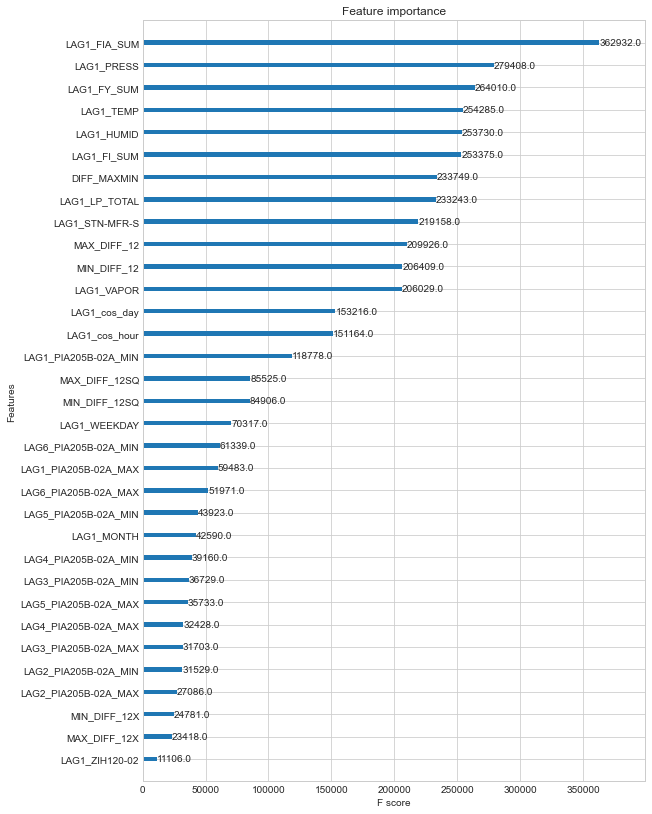

In [588]:
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(9,14))
plot_importance(XGB_model, ax)

In [564]:
joblib.dump(XGB_model, './XGB_1123_02603_best.pkl')

['./XGB_1123_02603_best.pkl']

In [565]:
'LAG1_PIA205B-02A_MIN', 'LAG1_PIA205B-02A_MAX', 'LAG1_FI_SUM',
       'LAG1_STN-MFR-S', 'LAG1_TEMP', 'LAG1_WEEKDAY', 'LAG1_cos_day',
       'LAG1_cos_hour', 'LAG2_PIA205B-02A_MIN', 'LAG2_PIA205B-02A_MAX',
       'LAG3_PIA205B-02A_MIN', 'LAG3_PIA205B-02A_MAX', 'LAG4_PIA205B-02A_MIN',
       'LAG4_PIA205B-02A_MAX', 'LAG5_PIA205B-02A_MIN', 'LAG5_PIA205B-02A_MAX',
       'LAG6_PIA205B-02A_MIN', 'LAG6_PIA205B-02A_MAX', 'MIN_DIFF_12',
       'MAX_DIFF_12', 'MIN_DIFF_12SQ', 'MAX_DIFF_12SQ', 'MIN_DIFF_12X',
       'MAX_DIFF_12X', 'DIFF_MAXMIN'
 XGBRegressor(n_estimators=2000,
                     min_child_weight=4,
                     learning_rate=0.02,
                     max_depth=20,
                     n_jobs=-1,
                         alpha=0.1,
                         colsample_bytree=0.9,
                         subsample=1.0,
                    eval_metric='mae')

Index(['LAG1_PIA205B-02A_MIN', 'LAG1_PIA205B-02A_MAX', 'LAG1_FI_SUM',
       'LAG1_STN-MFR-S', 'LAG1_TEMP', 'LAG1_WEEKDAY', 'LAG1_cos_day',
       'LAG1_cos_hour', 'LAG2_PIA205B-02A_MIN', 'LAG2_PIA205B-02A_MAX',
       'LAG3_PIA205B-02A_MIN', 'LAG3_PIA205B-02A_MAX', 'LAG4_PIA205B-02A_MIN',
       'LAG4_PIA205B-02A_MAX', 'LAG5_PIA205B-02A_MIN', 'LAG5_PIA205B-02A_MAX',
       'LAG6_PIA205B-02A_MIN', 'LAG6_PIA205B-02A_MAX', 'MIN_DIFF_12',
       'MAX_DIFF_12', 'MIN_DIFF_12SQ', 'MAX_DIFF_12SQ', 'MIN_DIFF_12X',
       'MAX_DIFF_12X', 'DIFF_MAXMIN'],
      dtype='object')

In [589]:
#XGB제출 파일 만들기
XGB_predicted_submission = XGB_model.predict(test_data)
#제출 파일에 예측값 채워넣기
submission.iloc[:,1:] = XGB_predicted_submission
submission.to_csv('XGB_answer_11231856.csv', index=False)

In [646]:
#extratreeregressor
start = time.time()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

EXTRA_model = ExtraTreesRegressor(max_depth=32,
                                  n_estimators=2000,
                              min_samples_leaf=3,
                                  min_samples_split=5,
                             n_jobs=-1)



EXTRA_model.fit(x_train, y_train)
EXTRA_y_train = EXTRA_model.predict(x_train)
EXTRA_y_test = EXTRA_model.predict(x_test)
EXTRA_y_sub = EXTRA_model.predict(test_data)
print("train score: {:.8f}".format(EXTRA_model.score(x_train, y_train)))
print("test score: {:.8f}".format(EXTRA_model.score(x_test, y_test)))
y_pred = EXTRA_model.predict(x_test)
print("MAE score: {:.8f}".format(mean_absolute_error(y_test, y_pred)))
print("runtime:", time.time()-start)

train score: 0.99986981
test score: 0.99946328
MAE score: 0.01054989
runtime: 190.21198081970215


In [647]:
#차원 확인부터 하기
print(y_train_concat.shape[0])
print(y_test_concat.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

76805
32917
76805
32917


In [648]:
#stacking 전에 각 모델들의 예측값을 훈련데이터로 만들어주는 작업
dataframe = [RF_y_train, EXTRA_y_train, XGB_y_train, RF_y_test, EXTRA_y_test, XGB_y_test, RF_y_sub, EXTRA_y_sub, XGB_y_sub]
dfs = []
for i in tqdm(dataframe):
    df = pd.DataFrame(i)
    dfs.append(df)
    
y_train_concat = pd.concat((dfs[0], dfs[1], dfs[2]), axis=1)
y_test_concat = pd.concat((dfs[3], dfs[4], dfs[5]), axis=1)
y_sub_concat = pd.concat((dfs[6], dfs[7], dfs[8]), axis=1)

y_train_concat.columns = ['min_RF', 'max_RF', 'min_EXTRA', 'max_EXTRA', 'min_XGB', 'max_XGB']
y_test_concat.columns = ['min_RF', 'max_RF', 'min_EXTRA', 'max_EXTRA', 'min_XGB', 'max_XGB']
y_sub_concat.columns = ['min_RF', 'max_RF', 'min_EXTRA', 'max_EXTRA', 'min_XGB', 'max_XGB']

100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9013.55it/s]


In [653]:
#stacking meta model
start = time.time()
stack_model = RandomForestRegressor(max_depth=15,
                                  n_estimators=2000,
                              min_samples_leaf=5,
                                  min_samples_split=5,
                             n_jobs=-1)

stack_model.fit(y_train_concat, y_train)
print("train score: {:.8f}".format(stack_model.score(y_train_concat, y_train)))
print("test score: {:.8f}".format(stack_model.score(y_test_concat, y_test)))
y_pred = stack_model.predict(y_test_concat)
print("MAE score: {:.8f}".format(mean_absolute_error(y_test, y_pred)))
print("runtime:", time.time()-start)

train score: 0.99995366
test score: 0.99949661
MAE score: 0.01018108
runtime: 146.52756476402283


In [611]:
#스태킹 제출 파일 만들기
stack_predicted_submission = stack_model.predict(y_sub_concat)
#제출 파일에 예측값 채워넣기
submission.iloc[:,1:] = stack_predicted_submission
submission.to_csv('stack_RF_11231940.csv', index=False)

In [612]:
#stacking meta model
start = time.time()
stack_xgb_model = XGBRegressor(n_estimators=2000,
                 min_child_weight=4,
                 learning_rate=0.02,
                 max_depth=20,
                 n_jobs=-1,
                     alpha=0.1,
                     colsample_bytree=0.9,
                     subsample=1.0,
                eval_metric='mae')

stack_xgb_model.fit(y_train_concat, y_train)
print("train score: {:.8f}".format(stack_xgb_model.score(y_train_concat, y_train)))
print("test score: {:.8f}".format(stack_xgb_model.score(y_test_concat, y_test)))
y_pred = stack_xgb_model.predict(y_test_concat)
print("MAE score: {:.8f}".format(mean_absolute_error(y_test, y_pred)))
print("runtime:", time.time()-start)

train score: 0.99998904
test score: 0.99946712
MAE score: 0.01036917
runtime: 298.8029863834381


In [613]:
#스태킹 제출 파일 만들기
stack_predicted_submission = stack_xgb_model.predict(y_sub_concat)
#제출 파일에 예측값 채워넣기
submission.iloc[:,1:] = stack_predicted_submission
submission.to_csv('stack_xgb_11231942.csv', index=False)

In [649]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#앞서 세 가지 level1 model에서 train과 test로 나눴던 것을 재병합 시키고, 이를 kfold로 다시 무작위로 섞어서 새로운 train test를 만들 것임
x_ens = pd.concat((y_train_concat,y_test_concat),axis=0)
y_ens = pd.concat((y_train,y_test),axis=0)

In [652]:
start = time.time()

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
folds = []
for train_idx, val_idx in kfold.split(x,y):
    folds.append((train_idx, val_idx))

STACK_RF_model_dict = {}
MAE = []

for f in range(10):
    print("----------{}회째 folds-----------".format(f+1))
    train_idx, val_idx = folds[f]

    x_ens_train, x_ens_val, y_ens_train, y_ens_val = x_ens.iloc[train_idx], x_ens.iloc[val_idx], y_ens.iloc[train_idx], y_ens.iloc[val_idx]

    STACK_RF_model = RandomForestRegressor(max_depth=30,
                                  n_estimators=2000,
                              min_samples_leaf=3,
                                  min_samples_split=3,
                             n_jobs=-1)

    STACK_RF_model.fit(x_ens_train, y_ens_train)
    y_ens_pred = STACK_RF_model.predict(x_ens_val)
    mae = mean_absolute_error(y_ens_val, y_ens_pred)
    MAE.append(mae)
    print("{} fold MAE score: {:.8f}".format(f+1,mae))
    STACK_RF_model_dict[f] = STACK_RF_model

MAE_mean = np.array(MAE)
print("---------------------------")
print("k-fold MAE mean: {:.8f}".format(np.mean(MAE_mean)))


submission.iloc[:,1:]=0
for fold in range(10):
    submission.iloc[:,1:] += STACK_RF_model_dict[fold].predict(y_sub_concat)/10
print("runtime:", time.time()-start)

submission.to_csv('STACK_RF_answer_11232117.csv', index=False)

----------1회째 folds-----------
1 fold MAE score: 0.00574940
----------2회째 folds-----------
2 fold MAE score: 0.00621490
----------3회째 folds-----------
3 fold MAE score: 0.00551994
----------4회째 folds-----------
4 fold MAE score: 0.00568639
----------5회째 folds-----------
5 fold MAE score: 0.00553954
----------6회째 folds-----------


KeyboardInterrupt: 

In [ ]:
start = time.time()

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
folds = []
for train_idx, val_idx in kfold.split(x,y):
    folds.append((train_idx, val_idx))

STACK_XGB_model_dict = {}
MAE = []

for f in range(10):
    print("----------{}회째 folds-----------".format(f+1))
    train_idx, val_idx = folds[f]

    x_train, x_val, y_train, y_val = x.iloc[train_idx], x.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]

    STACK_XGB_model = XGBRegressor(n_estimators=2000,
                 min_child_weight=4,
                 learning_rate=0.02,
                 max_depth=20,
                 n_jobs=-1,
                     alpha=0.1,
                     colsample_bytree=0.9,
                     subsample=1.0,
                eval_metric='mae')

    STACK_XGB_model.fit(x_train, y_train)
    y_pred = STACK_XGB_model.predict(x_val)
    mae = mean_absolute_error(y_val, y_pred)
    MAE.append(mae)
    print("{} fold MAE score: {:.8f}".format(f+1,mae))
    STACK_XGB_model_dict[f] = STACK_XGB_model

MAE_mean = np.array(MAE)
print("---------------------------")
print("k-fold MAE mean: {:.8f}".format(np.mean(MAE_mean)))


submission.iloc[:,1:]=0
for fold in range(10):
    submission.iloc[:,1:] += STACK_XGB_model_dict[fold].predict(test_data)/10
print("runtime:", time.time()-start)

submission.to_csv('STACK_XGB_answer_11232000.csv', index=False)

In [120]:
#stacking model 그리드서치
start = time.time()

rf = RandomForestRegressor(n_jobs=-1)
params = {"n_estimators":[1000],
    "max_depth":(15,20,25,30,35),
         "min_samples_leaf":(3,5,7),
         "min_samples_split":(3,5,7)}

grid_cv = GridSearchCV(rf,
                      param_grid=params)

grid_cv.fit(y_train_concat, y_train)

print(grid_cv.best_estimator_)
stack_model = grid_cv.best_estimator_
stack_model.fit(y_train_concat, y_train)
print("train score: {:.8f}".format(model.score(y_train_concat, y_train)))
print("test score: {:.8f}".format(model.score(y_test_concat, y_test)))
y_pred = stack_model.predict(y_test_concat)
print("MAE score: {:.8f}".format(mean_absolute_error(y_test, y_pred)))
print("runtime:", time.time()-start)

RandomForestRegressor(max_depth=30, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=1000, n_jobs=-1)


NameError: name 'model' is not defined

In [ ]:
def plot_feature_importances(model):
    n_features = x.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), x.columns)
    plt.xlabel("feature importances")
    plt.ylabel("features")
    plt.ylim(-1, n_features)

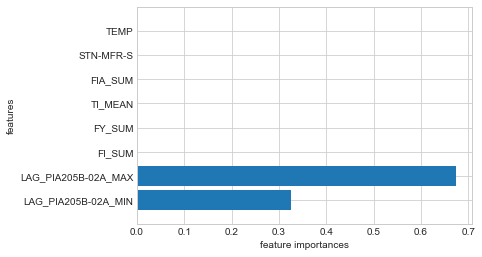

In [46]:
plot_feature_importances(model)

In [ ]:
#본선###
#1 #최고기록 0.04026
#LAG5(50분전까지) 추가한 모델, ZIH102-02, PRESSURE-S 빼고 만든 모델
#test:train = 4:6
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
#train score: 0.99983933
#test score: 0.99932353
#MAE score: 0.01136770

#2 #최고기록 0.03833
#"ZIH120-02", "PRESSURE-S", "LP_TOTAL", "FI_SUM","FY_SUM","TI_MEAN" 뺌
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
#train score: 0.99981781
#test score: 0.99929976
#MAE score: 0.01125905

#3
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
#HOUR 추가
train score: 0.99982371
test score: 0.99929506
MAE score: 0.01128554
    
#4
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
#HOUR 추가 #"ZIH120-02", "PRESSURE-S", "LP_TOTAL", "FI_SUM","FY_SUM","TI_MEAN" 뺌
train score: 0.99981923
test score: 0.99929823
MAE score: 0.01126622
    
#5
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
#HOUR 추가 #"ZIH120-02", "PRESSURE-S", "LP_TOTAL", "FI_SUM","FY_SUM","TI_MEAN" 뺌
#standardscaler
train score: 0.99981885
test score: 0.99929644
MAE score: 0.01125824

#5 최고기록: 0.03675
#train:test = 8:2
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
train score: 0.99983249
test score: 0.99911739
MAE score: 0.01117610

#6
#train:test = 8:2
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
#HOUR, MONTH 추가
#LAG6까지
CV score list: [-0.01130643 -0.01158868 -0.01086356 -0.01128588 -0.01139795]
CV score: -0.01128850
train score: 0.99982754
test score: 0.99914690
MAE score: 0.01113115

#train:test = 7:3
#RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=2000, n_jobs=-1)
#HOUR, MONTH 추가
#LAG6까지
CV score list: [-0.0114803  -0.01123492 -0.01170933 -0.01136669 -0.011345  ]
CV score: -0.01142725
train score: 0.99981901
test score: 0.99934952
MAE score: 0.01116012

#9
#그리드서치
#HOUR, MONTH 추가
#LAG6까지
#RandomForestRegressor(max_depth=32, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, n_jobs=-1)
train score: 0.99982013
test score: 0.99934110
MAE score: 0.01116557
    
#10
#"FI_SUM","FY_SUM", "HOUR" 뺌
#RandomForestRegressor(max_depth=32, min_samples_leaf=3, min_samples_split=5, n_estimators=1000, n_jobs=-1)
CV score list: [-0.0114596  -0.01120657 -0.01169672 -0.01134974 -0.01131956]
CV score: -0.01140644
train score: 0.99981879
test score: 0.99934246
MAE score: 0.01114183
    
#11
LGBMRegressor(metric="mae",
                               max_depth=25,
                      n_estimators=2000,
                        objective='regression',                                  
                             n_jobs=-1,
                     num_leaves=150,
                     min_child_samples=15,
                     learning_rate=0.01,
                     bagging_fraction=0.9,
                     feature_fraction=0.8,
                     bagging_freq=3)   #0.04928

#12
XGBRegressor(n_estimators=2000,
                     min_child_weight=1.5,
                     learning_rate=0.01,
                     max_depth=20,
                     n_jobs=-1,
                     reg_alpha=0.2,
                     subsample=0.8,
                    eval_metric='mae')  #0.03824
train score: 0.99993538
test score: 0.99938033
MAE score: 0.01135989
    
#13 #0.03738 스태킹하니까 세개의 모델 각각 점수보다 더 좋은 점수 나오긴 함.
stack_model = RandomForestRegressor(max_depth=32,
                                  n_estimators=2000,
                              min_samples_leaf=3,
                                  min_samples_split=5,
                             n_jobs=-1)
train score: 0.99995329
test score: 0.99936573
MAE score: 0.01123502

#20
#시간 푸리에 변환
#습도, 강수량 추가
#lag6
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
train score: 0.99982995
test score: 0.99914354
MAE score: 0.01111632
runtime: 496.6320958137512

#21
#LGBM 0.04671  RF 0.03917  xgb 0.04271

#25 0.039xx
"HOUR","sin_52555_1","cos_1008_1", "cos_4380_1", "sin_144_1", "FY_SUM", "WATER"] 제외
RandomForestRegressor(max_depth=32, min_samples_leaf=3, min_samples_split=5, n_estimators=3000, n_jobs=-1)
train score: 0.99982083
test score: 0.99933834
MAE score: 0.01116788
runtime: 813.1964380741119
    
    
#42 0.3565
#변수: lag1~6, weekday, cos_day, temp, ...
RandomForestRegressor(max_depth=32, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
10-fold


In [ ]:
#train score, test score 기록

#221016_22_24_19 제출 score
#0.9994708844860428
#0.999026318398519

#221016_22_39_19
#0.9996814115959253
#0.9990217147662193

#221017_00_06_07 최고기록 0.01459
#RandomForestRegressor(max_depth=13, min_samples_leaf=3, min_samples_split=5,n_estimators=200, n_jobs=-1)
#0.9995154756761102
#0.9990507329275921

#221017_14_55_31
#RandomForestRegressor(max_depth=13, n_estimators=200, n_jobs=-1)
#0.9996905813098902
#0.9990191695231758

#221017_15_04_20
#0.999527756103062
#0.9990543206059128

#221017_15_23_18
#XGBRegressor(max_depth=10, n_estimators=200)
#0.9999439873799316
#0.9990631398692372

#221017_15_55_12 최고기록 0.01457
#RandomForestRegressor(max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_jobs=-1)
#0.999376689775935
#0.999078655783783

#221017_16_12_18 최고기록 0.01453
#RandomForestRegressor(max_depth=12, min_samples_leaf=5, min_samples_split=15, n_estimators=200, n_jobs=-1)
#0.9993330577647948
#0.9990781495964784

#221017_16_17_18
#RandomForestRegressor(max_depth=12, min_samples_leaf=5, min_samples_split=15, n_estimators=300, n_jobs=-1)
#0.9993367275454459
#0.9990824090147556

#RandomForestRegressor(max_depth=12, min_samples_split=15, n_estimators=400, n_jobs=-1)
#0.9992007488967085
#0.9990191622449052

#221017_16_35_11
#RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=15, n_estimators=600, n_jobs=-1)
#0.9992623549689047
#0.9990744113563048

#221018_20_05_13 #최고기록 0.01452
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=600, n_jobs=-1)
#0.9993586267130561
#0.9990807207661812

#221018_20_29_19  #최고기록 0.01445
#ZIH102-02 빼고 만든 모델
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=600, n_jobs=-1)
#0.9993538306274337
#0.9990768339677375

#221018_20_37_17 #최고기록 0.01443
#ZIH102-02, PRESSURE-S 빼고 만든 모델
#변수를 빼니까 점수가 낮아진다.
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=600, n_jobs=-1)
#0.9993548738544262
#0.9990784470456

#221018_20_51_12
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=600, max_features=5, n_jobs=-1)
#0.9993196105130537
#0.9990999405465295

#221019_01_47_21
#ZIH102-02 빼고 만든 모델
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=18, n_estimators=800, n_jobs=-1)
#train score: 0.99933351
#test score: 0.99908157
#MAE score: 0.01648075

#221019_01_59_22 #최고기록 0.01442
#ZIH102-02, PRESSURE-S 빼고 만든 모델
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=2000, n_jobs=-1)
#train score: 0.99935161
#test score: 0.99908149
#MAE score: 0.01646420

#221019_02_10_11
#ZIH102-02, PRESSURE-S 빼고 만든 모델
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=2000, n_jobs=-1)
#train score: 0.99937609
#test score: 0.99908183
#MAE score: 0.01642287

#221019_18_50_17
#ZIH102-02, PRESSURE-S, LP_TOTAL 빼고 만든 모델
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=2000, n_jobs=-1)

#221022_18_11_06
#LAG4(40분전까지) 추가한 모델
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=600, n_jobs=-1)
#train score: 0.99969874
#test score: 0.99922996
#MAE score: 0.01194716

#221023_15_09_06 최고기록 0.011
#LAG4(40분전까지) 추가한 모델
#RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=15, n_estimators=800, n_jobs=-1)
#train score: 0.99969783
#test score: 0.99923408
#MAE score: 0.01194080

#221023_18_55_06 최고기록: 0.01078
#LAG5(50분전까지) 추가한 모델
#RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=15, n_estimators=1000, n_jobs=-1)
#train score: 0.99971353
#test score: 0.99924403
#MAE score: 0.01161388

#221023_19_00_07 최고기록: 0.01076
#LAG5(50분전까지) 추가한 모델
#RandomForestRegressor(max_depth=18, min_samples_leaf=5, min_samples_split=15, n_estimators=1000, n_jobs=-1)
#train score: 0.99972204
#test score: 0.99924495
#MAE score: 0.01150279

#24회
#221023_19_08_06 최고기록: 0.01074
#LAG5(50분전까지) 추가한 모델
#RandomForestRegressor(max_depth=21, min_samples_leaf=5, min_samples_split=15, n_estimators=2000, n_jobs=-1)
#train score: 0.99972285
#test score: 0.99924699
#MAE score: 0.01149084

#25회
#221023_19_14_07 최고기록: 0.01066
#LAG5(50분전까지) 추가한 모델
#RandomForestRegressor(max_depth=21, min_samples_leaf=5, min_samples_split=5, n_estimators=1000, n_jobs=-1)
#train score: 0.99975071
#test score: 0.99926274
#MAE score: 0.01139570

#26회
#221023_19_20_07 최고기록: 0.01063
#LAG5(50분전까지) 추가한 모델, ZIH102-02, PRESSURE-S, LP_TOTAL 빼고 만든 모델
#RandomForestRegressor(max_depth=21, min_samples_leaf=5, min_samples_split=5, n_estimators=1000, n_jobs=-1)
#train score: 0.99974906
#test score: 0.99925158
#MAE score: 0.01140494

#27회
#221023_19_26_06
#LAG5(50분전까지) 추가한 모델
#RandomForestRegressor(max_depth=24, min_samples_leaf=5, min_samples_split=5, n_estimators=1000, n_jobs=-1)
#train score: 0.99975130
#test score: 0.99926066
#MAE score: 0.01138927

#28회
#221023_19_31_06
#LAG5(50분전까지) 추가한 모델, ZIH102-02, PRESSURE-S, LP_TOTAL 빼고 만든 모델
#RandomForestRegressor(max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=1000, n_jobs=-1)
#train score: 0.99975016
#test score: 0.99926023
#MAE score: 0.01139760

#29회
#221023_19_39_06 최고기록:0.01056
#LAG5(50분전까지) 추가한 모델, ZIH102-02, PRESSURE-S, LP_TOTAL 빼고 만든 모델
#RandomForestRegressor(max_depth=24, min_samples_leaf=3, min_samples_split=3, n_estimators=1000, n_jobs=-1)
#train score: 0.99982073
#test score: 0.99929529
#MAE score: 0.01129478

#30회
#221023_19_44_07
#LAG5(50분전까지) 추가한 모델, ZIH102-02, PRESSURE-S, LP_TOTAL 빼고 만든 모델
#RandomForestRegressor(max_depth=24, n_estimators=1000, n_jobs=-1)
#train score: 0.99993794
#test score: 0.99935242
#MAE score: 0.01129979

#31회
#221023_19_49_08
#LAG5(50분전까지) 추가한 모델, ZIH102-02, PRESSURE-S, LP_TOTAL 빼고 만든 모델
#RandomForestRegressor(max_depth=24, min_samples_leaf=2, min_samples_split=2, n_estimators=1000, n_jobs=-1)
#train score: 0.99987238
#test score: 0.99932482
#MAE score: 0.01126985

#32회
#LAG5(50분전까지) 추가한 모델, ZIH102-02, PRESSURE-S, LP_TOTAL 빼고 만든 모델
#RandomForestRegressor(max_depth=24, min_samples_leaf=2, min_samples_split=2, n_estimators=2000, n_jobs=-1)
#train score: 0.99987157
#test score: 0.99932224
#MAE score: 0.01126574

#33회
#LAG5(50분전까지) 추가한 모델, ZIH102-02, PRESSURE-S, LP_TOTAL 빼고 만든 모델
#RandomForestRegressor(max_depth=27, min_samples_leaf=3, min_samples_split=3, n_estimators=2000, n_jobs=-1)
#train score: 0.99982135
#test score: 0.99929883
#MAE score: 0.01128869

